# Analizando la biblia:
## 3 evangelios.

In [6]:
"""Importamos librerias"""
#%matplotlib inline
from spacy import displacy
import nltk
import numpy as np
import pandas as pd
import spacy
import sys
import re
from collections import defaultdict
from nltk.cluster import kmeans, cosine_distance
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import collections
import numpy
#nltk.download("punkt")

In [7]:
def read_array():
    """leemos el texto a analizar. En este caso los 3 primeros evangelios."""
    corpus_filename = "bibliamarcada.txt"
    file = open(corpus_filename, "r", encoding="utf8")
    text = file.read()
    return text
#print (read_array())

In [8]:
def concurrence_of_words_custom(text):
    """dato que puede ser útil, es ver las cooncurrencias relativamente de ciertas palabras"""
    book =  text.split()
    cnt = collections.Counter()
    word_cocurrence = ["espíritu", "Santo","Dios", "Jesús", "pecado", "misericordia", "amor", "odio"]
    for i in word_cocurrence:
        for word in book:
            if i==word:
                cnt[word] +=1 
    return (cnt)

def should_count():
    word_more_import = concurrence_of_words_custom(read_array())
    Conteo = pd.DataFrame.from_dict(dict(word_more_import), orient='index')
    Conteo = Conteo.sort_values(by=0, ascending=False)
    Conteo = Conteo.reset_index().rename(columns={'index':'Palabras', 0:'Frecuencias'})
    print(Conteo)

should_count()

       Palabras  Frecuencias
0         Jesús          397
1          Dios          103
2      espíritu           28
3  misericordia           22
4         Santo           17
5        pecado            4
6          amor            4


In [9]:
#---"""modelo en español de la libreria spacy"""
nlp = spacy.load("es_core_news_sm")
#nlp = spacy.load("es")

In [10]:
versiculo ="Bienaventurados los misericordiosos, porque ellos alcanzarán misericordia."
doc= nlp(versiculo)
displacy.render(doc, style="dep", jupyter=True, options={'distance':90})

In [12]:
def procingtext():
    """cargamos el cuerpo de datos. Dividimos por titulo y cuerpo, en este caso 
    por capitulos de la biblia"""

    document = {
        "title": None,
        "body": None
    }    
    new_document = False
    text = read_array()
    text = text.lower()
    new_chapter=False
    text =  re.split("\n", text)
    for line in text:
        if line.strip() == "-":
            new_document = True
            document = {
                "title": None,
                "body": None
            }
            
        elif line.strip() == "":
            continue
        elif new_document:
            document["title"] = line.strip()
            new_document = False
        else:
            document["body"] = line.strip()
            yield(document)


### Guardamos en archivo el texto procesado. Hacemos token a cada palabra del cuerpo  

In [13]:
def save_in_file(file):
    """Elimino articulos, numeros, y palabras de longitud menor a 4"""
    with open(file, "w", encoding="utf-8") as fh:
         for idx, document in enumerate(procingtext()):
            for sentence in nltk.sent_tokenize(document["body"], language="spanish"):
                for token in nlp(sentence):
                        if not ((token.is_stop) or (token.text.isdigit()) or len(token)<4) :
                            print(token.text, token.lemma_, token.pos_, token.dep_, token.head,
                               file=fh)
                            continue
                print(file=fh)
            print("="*80, file=fh)
            if idx > 100:
                break
save_in_file("santabiblia.conll")

In [40]:
def conll_iterator(file):
    """ contextualiza datos recientemente creados"""
    context = []
    with open(file, "r", encoding="utf-8") as fh:
        for line in fh:
            if line.strip() == "":
                yield context
                context = []
            elif line.strip() == ("=" * 80):
                continue
            else:
                (token, lemma, pos, dep, head) = line.strip().split()
                context.append({
                    "token": token,
                    "lemma": lemma,
                    "pos": pos,
                    "dep": dep,
                    "head": head
                })
                
for word in conll_iterator("santabiblia.conll"):
    words = word
    #print(word)


In [41]:
pd.DataFrame(word)

,dep,head,lemma,pos,token
0,nmod,tú,ayunar,NOUN,ayunes
1,ROOT,unge,ungir,ADJ,unge
2,obj,unge,cabeza,NOUN,cabeza
3,conj,unge,lavar,ADJ,lava
4,obj,lava,rostro,NOUN,rostro
5,acl,18,mostrar,VERB,mostrar
6,obj,mostrar,hombre,NOUN,hombres
7,acl,hombres,ayuno,ADJ,ayunas
8,conj,unge,padre,NOUN,padre
9,acl,padre,secretar,NOUN,secreto


### Creamos diccionario de caracteristiscas.

In [19]:
words_features = {}

for context in conll_iterator("./santabiblia.conll"):
    for idx, word in enumerate(context):
        lemma = word["lemma"]
        if lemma in words_features:
              word_features = words_features[lemma]
        else:
              word_features = {}

        features = [
            "token__{}".format(word["token"]),
            "pos__{}".format(word["pos"]),
            "dep__{}__{}".format(word["dep"], word["head"])
        ]

        for feature in features:
            if feature not in word_features:
                word_features[feature] = 0
            word_features[feature] += 1

        if idx > 0:
            previous_word = context[idx-1]
            previous_word_lemma = context[idx-1]["lemma"]
            features = [
            "previous_token__{}".format(previous_word["token"]),
            "previous_pos__{}".format(previous_word["pos"]),
            "previous_lemma__{}".format(previous_word_lemma)
            ]

            for feature in features:
                if feature not in word_features:
                      word_features[feature] = 0
                word_features[feature] += 1

        if idx < len(context) - 1:
            next_word = context[idx+1]
            next_word_lemma = context[idx-1]["lemma"]
            features = [
            "next_token__{}".format(next_word["token"]),
            "next_pos__{}".format(next_word["pos"]),
            "next_lemma__{}".format(next_word_lemma)
            ]

        for feature in features:
            if feature not in word_features:
                word_features[feature] = 0
            word_features[feature] += 1

        words_features[lemma] = word_features

In [20]:
word_to_index = {word: idx for idx, word in enumerate(sorted(words_features.keys()))}
word_features_list = [words_features[w] for w in sorted(words_features.keys())]
print(word_to_index)
#word_features_list

{'1.12': 0, '1.14': 1, '1.19': 2, '11.2': 3, '12.57': 4, '3.21': 5, '3.23': 6, '4.14': 7, '6.17': 8, '6.20': 9, '6.27': 10, 'abajar': 11, 'abiud': 12, 'aborrecer': 13, 'abraham': 14, 'abrir': 15, 'abrogar': 16, 'abías': 17, 'acaz': 18, 'acercar': 19, 'acontecer': 20, 'acordar': 21, 'adorar': 22, 'adorarle': 23, 'adulterar': 24, 'adulterio': 25, 'adversario': 26, 'afligir': 27, 'aguar': 28, 'alabar': 29, 'alcanzar': 30, 'alegraos': 31, 'alguacil': 32, 'allá': 33, 'almud': 34, 'alrededor': 35, 'altar': 36, 'alto': 37, 'alumbrar': 38, 'amar': 39, 'aminadab': 40, 'amor': 41, 'amén': 42, 'amón': 43, 'andar': 44, 'andrés': 45, 'antiguo': 46, 'apacentar': 47, 'apagar': 48, 'aparecer': 49, 'aparición': 50, 'aposentar': 51, 'aquim': 52, 'aram': 53, 'arquelao': 54, 'arrepentimiento': 55, 'arrepentíos': 56, 'asentar': 57, 'austero': 58, 'aventador': 59, 'averiguar': 60, 'avisar': 61, 'ayunar': 62, 'ayuno': 63, 'azor': 64, 'año': 65, 'babilonio': 66, 'barca': 67, 'bautismo': 68, 'bautista': 69, 'b

In [21]:
from sklearn.feature_extraction import DictVectorizer

vectorizer = DictVectorizer()
words_matrix = vectorizer.fit_transform(word_features_list)
dense = DictVectorizer(sparse = False)
word_matrix = dense.fit_transform(word_features_list)

print(word_matrix)

[[2. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [22]:
vectorizer.feature_names_[:10]


['dep__ROOT__1.12',
 'dep__ROOT__11.2',
 'dep__ROOT__12.57',
 'dep__ROOT__3.21',
 'dep__ROOT__3.23',
 'dep__ROOT__6.20',
 'dep__ROOT__6.27',
 'dep__ROOT__abraham',
 'dep__ROOT__aconteció',
 'dep__ROOT__alumbre']

In [23]:
print(word_matrix.shape)


(537, 3776)


# Uso de sklearn 

In [42]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=200)
clusters = model.fit(words_matrix)


In [43]:
matrix_normed = word_matrix / word_matrix.max(axis=0)
variances = np.square(matrix_normed).mean(axis=0) - np.square(matrix_normed.mean(axis=0))
threshold_v = 0.001
red_matrix = np.delete(matrix_normed, np.where(variances < threshold_v), axis=1)

In [53]:
clusters_per_word = list(zip(sorted(word_to_index.keys()), clusters.labels_))
#clusters_per_word[:100]


# Viendo Clustering 

In [45]:
printer = [w for w, c in clusters_per_word if c == 188]
printer


['oponer', 'perecer', 'preso', 'proceder', 'salar']

In [46]:
printer = [w for w, c in clusters_per_word if c == 5]
printer


['decir']

In [47]:
printer = [w for w, c in clusters_per_word if c == 1]
printer


['aposentar',
 'consolación',
 'dejarla',
 'deudor',
 'fama',
 'guiador',
 'mandamiento',
 'mejilla',
 'misericordia',
 'ramá',
 'sendos',
 'venidero']

In [48]:
clusters.cluster_centers_

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# visualizando 

In [49]:
import sklearn.manifold

tsne = sklearn.manifold.TSNE(n_components=2, metric='cosine', init='pca', random_state=123)
matrix_dicc2d = tsne.fit_transform(red_matrix)

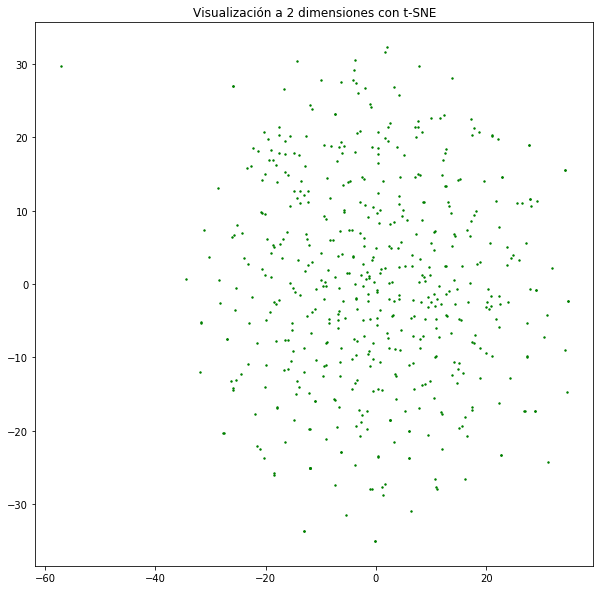

<Figure size 432x288 with 0 Axes>

In [50]:
plt.figure(figsize=(10,10)) 

plt.scatter(matrix_dicc2d[:, 0], matrix_dicc2d[:, 1], s=2, c='g')
plt.title("Visualización a 2 dimensiones con t-SNE")
plt.axis('tight')
plt.show()
plt.savefig("t-sne.png")

In [51]:
pointsspacy = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, matrix_dicc2d[word_to_index[word]])
            for word in word_to_index
        ]
    ],
    columns=["word", "x", "y"]
)

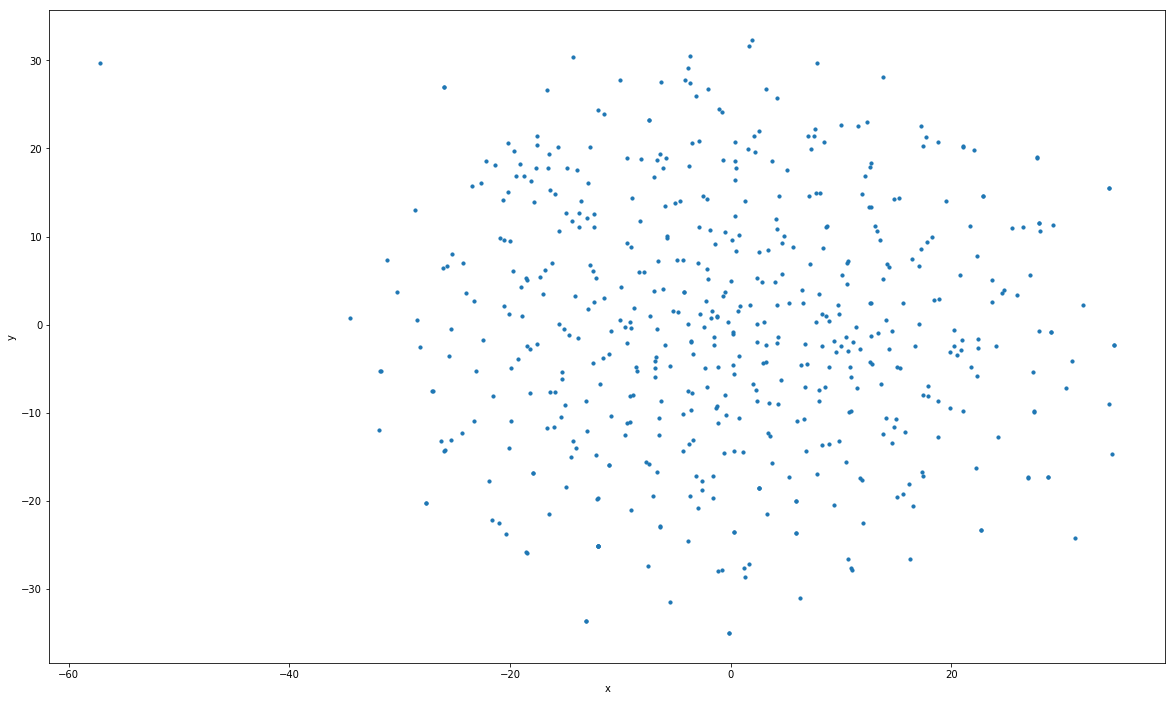

In [52]:
pointsspacy.plot.scatter("x", "y", s=10, figsize=(20, 12))